## Multi-omics data analysis using GNN

### Import necessary libraries

In [1]:

from pathlib import Path
import pickle
import json
import re
from datetime import datetime

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
    
import xgboost as xgb
from statsmodels.stats.multitest import multipletests
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [4]:

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [5]:
from mofapy2.run.entry_point import entry_point as mofa_entrypoint

In [6]:
import GEOparse

In [7]:
from multiomics.study import Study

In [8]:
plot_settings = {
                'ytick.labelsize': 16,
                'xtick.labelsize': 16,
                'font.size': 22,
                'figure.figsize': (10, 5),
                'axes.titlesize': 22,
                'axes.labelsize': 18,
                'lines.linewidth': 2,
                'lines.markersize': 3,
                'legend.fontsize': 11,
                'mathtext.fontset': 'stix',
                'font.family': 'STIXGeneral'
                }

plt.style.use(plot_settings)

colors = ["#84a97e", "#fd7f82", "#807fff"]
sns.set_palette(sns.color_palette(colors))

## Load study

### Set the location for your data

In [9]:
annot_path = Path('./annot')
data_path = Path('./data')

### Create the Study placeholder

In [10]:
study = Study(data_path, annot_path, debug=True)

### Load mRNA data

In [11]:
df = study.loadData(modality='mRNA', 
                    filename='./data/mRNA/mRNA.csv')
df

Loading data/mRNA/mRNA.csv ...
Using ['TRB017', 'TRB002', 'BB14243', 'BB15476', 'TRB004', 'TRB015', 'BB14303', 'TRB007', 'TRB003', 'TRB025', 'BB14321', 'BB1543', 'TRB010', 'TRB012', 'TRB024', 'TRB021', 'TRB014', 'TRB006', 'TRB005', 'BB15324', 'TRB011', 'TRB027', 'TRB008', 'TRB013', 'BB14254']


,TRB017,TRB002,BB14243,BB15476,TRB004,TRB015,BB14303,TRB007,TRB003,TRB025,...,TRB021,TRB014,TRB006,TRB005,BB15324,TRB011,TRB027,TRB008,TRB013,BB14254
ID,,,,,,,,,,,,,,,,,,,,,
0,27.141925,22.254236,12.438534,20.381747,11.991429,18.840018,16.874091,23.763798,19.427138,24.850219,...,10.097914,21.944769,23.216084,12.831742,11.876636,14.798594,25.809134,14.318038,20.391897,12.118440
1,15.527648,16.579369,16.213342,28.080716,19.045678,23.850979,28.702378,26.150019,11.497817,13.002826,...,24.121238,12.764559,18.403375,11.664405,27.064750,24.985295,26.023204,11.929203,14.491879,27.085832
2,24.854116,17.895489,15.040621,18.694766,27.104559,12.170958,17.260979,15.797649,14.607564,14.314294,...,11.427994,18.735513,20.550616,27.586801,25.118534,17.568939,12.782624,11.841666,21.393502,27.727858
3,20.537073,16.574358,21.475750,15.253397,24.363123,13.975615,20.961775,22.033500,9.300532,17.113357,...,9.773337,12.194883,8.999005,23.962021,14.984853,6.816493,20.561326,8.648489,24.493725,15.325803
4,21.586383,13.906842,17.817620,17.336705,15.959727,23.904382,17.099623,28.746897,16.596426,13.272121,...,22.981081,19.379362,29.476954,16.690190,27.388179,14.177288,24.623047,22.927943,27.272937,17.377556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12458,9.866772,13.991935,12.661517,23.151151,14.984757,28.410867,15.087096,24.909136,12.378997,21.723087,...,10.799981,14.220542,21.467245,20.349841,11.692469,25.189494,14.243920,26.298398,12.635038,11.674077
12459,26.497440,26.286923,24.828086,33.796126,30.164445,35.156991,24.939634,33.326128,33.471893,16.945063,...,20.277088,22.634426,23.977004,34.896995,22.562577,33.198017,17.738571,34.889016,20.169260,19.932902
12460,27.683984,10.827790,24.586911,28.558108,27.004022,23.251840,13.785159,25.213938,10.079993,13.368665,...,24.759242,18.875955,27.317155,25.946487,13.226114,10.865536,18.470440,11.494179,15.152710,10.321537


### Methylation

In [12]:
df = study.loadData(modality='Methylation', 
                    filename='./data/Methylation/Methylation.csv')
df

Loading data/Methylation/Methylation.csv ...
Using ['TRB017', 'BB14206', 'TRB002', 'BB14243', 'TRB016', 'BB15476', 'TRB004', 'TRB015', 'BB14303', 'TRB007', 'TRB003', 'TRB025', 'BB14321', 'BB1543', 'TRB010', 'TRB012', 'TRB024', 'TRB021', 'BB14294', 'TRB014', 'TRB006', 'TRB005', 'BB14277', 'BB15324', 'TRB019', 'TRB011', 'TRB027', 'TRB008', 'TRB013', 'BB14254']


,TRB017,BB14206,TRB002,BB14243,TRB016,BB15476,TRB004,TRB015,BB14303,TRB007,...,TRB006,TRB005,BB14277,BB15324,TRB019,TRB011,TRB027,TRB008,TRB013,BB14254
ID,,,,,,,,,,,,,,,,,,,,,
0,1.251978,0.935000,0.977377,0.518694,1.017019,1.197135,0.882045,0.932927,0.825781,1.192204,...,1.275040,0.778615,1.019162,0.583703,1.242583,0.899513,1.301187,1.523246,1.297755,0.792831
1,0.996350,0.861528,0.556123,1.145913,0.799728,1.004839,1.383595,0.835487,0.772205,1.215621,...,0.765221,1.085462,0.470438,1.541846,1.100180,1.620317,0.325762,0.295453,1.774441,1.042219
2,1.912951,0.978085,0.719882,1.402976,1.736993,0.640271,1.030374,1.096304,1.869825,1.282626,...,1.744465,0.755250,1.515029,1.868809,1.314514,1.747359,0.945451,1.349900,0.895000,0.660859
3,0.901429,1.713293,0.261136,0.811302,1.046528,0.893487,1.177758,1.216237,1.226928,0.077392,...,1.322776,0.641148,1.066177,0.988881,0.300437,1.294233,1.103301,1.346180,0.511282,0.914955
4,1.748067,1.348759,0.411713,1.541748,0.156092,0.982991,1.282651,1.167450,1.334154,1.468620,...,1.737286,1.380095,1.578195,1.447132,0.909768,1.116391,1.042341,1.636084,1.311655,1.716641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,1.340635,1.518381,1.087454,1.673285,1.478676,1.181819,1.400630,1.110705,1.644143,1.022120,...,1.353467,1.354971,0.808828,1.774963,1.145441,1.523893,1.143445,1.414698,1.186646,1.145749
127,1.594982,1.231391,1.163631,0.542533,0.915890,0.957864,0.827340,1.681644,1.238555,0.774235,...,1.410913,0.886467,0.960755,1.231684,0.777725,0.412865,1.102822,0.631852,1.166580,1.065176
128,1.520261,1.337881,0.169102,1.830926,1.597040,1.272395,0.567502,0.993969,1.405791,0.753268,...,1.161127,1.267389,1.778793,1.608656,0.637676,1.257739,1.158121,0.849825,0.401912,1.589764


### miRNA

In [13]:
df = study.loadData(modality='miRNA', 
                    filename='./data/miRNA/miRNA.csv')
df

Loading data/miRNA/miRNA.csv ...
Using ['TRB017', 'BB14206', 'TRB002', 'BB14243', 'TRB016', 'TRB007', 'TRB003', 'TRB025', 'BB1543', 'TRB010', 'TRB012', 'TRB024', 'TRB021', 'BB14294', 'TRB014', 'TRB006', 'TRB005', 'BB14277', 'TRB019', 'TRB011', 'TRB027', 'TRB008', 'TRB013', 'BB14254']


,TRB017,BB14206,TRB002,BB14243,TRB016,TRB007,TRB003,TRB025,BB1543,TRB010,...,TRB014,TRB006,TRB005,BB14277,TRB019,TRB011,TRB027,TRB008,TRB013,BB14254
ID,,,,,,,,,,,,,,,,,,,,,
0,6.808848,8.703068,18.213379,9.989959,6.128167,17.569026,17.094991,9.439780,13.776618,8.735043,...,15.816046,8.955524,14.061016,18.308098,8.877982,14.034093,9.967201,19.535380,10.329289,17.409552
1,6.455091,16.544757,8.819827,12.246329,12.082736,8.127627,6.075340,7.096595,8.149211,10.428950,...,5.354259,13.490492,9.594597,17.297076,9.792971,9.453083,17.254957,16.364761,9.222554,13.431471
2,7.754244,17.670585,14.508264,14.369117,12.144769,18.256099,18.032663,9.121799,9.289734,17.712854,...,13.411244,14.123496,15.921797,8.729984,6.368969,19.976773,5.372088,10.811756,16.595834,15.975242
3,12.770424,10.006777,7.195089,17.301412,9.564112,9.456857,11.392940,9.718360,9.281318,8.767900,...,11.693148,19.101290,8.116931,12.937862,13.697096,8.289771,7.481423,9.924944,17.069884,7.185848
4,12.155965,15.574465,12.421017,15.087239,16.874336,13.760902,11.408668,19.208544,12.554420,18.132837,...,17.949918,14.148153,11.792057,10.702101,12.927713,13.617748,16.920655,12.512575,6.376514,19.166101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025,12.617664,19.439097,17.183838,14.855203,11.934002,12.133084,17.197849,9.422555,8.785267,15.108697,...,6.666279,10.994023,16.818604,19.054030,20.756410,20.781700,20.023080,19.463627,7.712249,14.028602
2026,10.499413,10.613344,7.473927,4.885349,6.429012,4.688242,8.096395,17.546218,5.292294,9.378736,...,16.702286,4.699919,7.355829,16.262343,8.839254,13.538453,16.215662,9.207840,9.336807,16.455698
2027,14.966253,19.111297,15.458273,13.545088,9.168123,18.432387,15.460434,5.171840,7.205386,6.601037,...,9.007904,19.650731,8.461005,15.077845,8.657284,9.034434,17.260010,19.770018,10.177753,10.864737


### circRNA

In [14]:
df = study.loadData(modality='circRNA', 
                    filename='./data/circRNA/circRNA.csv')
df

Loading data/circRNA/circRNA.csv ...
Using ['TRB017', 'BB14206', 'TRB002', 'BB14243', 'TRB016', 'BB15476', 'TRB004', 'BB14303', 'TRB007', 'TRB003', 'TRB025', 'BB14321', 'BB1543', 'TRB010', 'TRB012', 'TRB024', 'TRB021', 'BB14294', 'TRB014', 'TRB006', 'TRB005', 'BB14277', 'BB15324', 'TRB019', 'TRB011', 'TRB027', 'TRB008', 'TRB013', 'BB14254']


,TRB017,BB14206,TRB002,BB14243,TRB016,BB15476,TRB004,BB14303,TRB007,TRB003,...,TRB006,TRB005,BB14277,BB15324,TRB019,TRB011,TRB027,TRB008,TRB013,BB14254
ID,,,,,,,,,,,,,,,,,,,,,
0,21.524530,10.986308,10.823356,11.401796,11.100939,6.805306,9.285759,16.322669,16.863004,10.576212,...,17.000921,20.872513,22.318305,15.761392,12.250598,14.923986,8.456998,12.258251,16.557772,19.710519
1,18.832027,21.505768,19.600241,19.649670,7.225479,12.714335,14.285818,7.227565,5.453540,22.072065,...,21.450733,5.147487,11.806284,6.720949,10.546238,7.057169,16.713094,11.084845,13.429720,8.234410
2,14.872080,6.847082,7.561413,20.889055,12.523564,16.458241,18.963373,15.242562,15.720313,18.800186,...,10.642288,10.405613,13.225330,15.481908,13.617659,21.751926,14.362897,8.180553,15.226288,13.127808
3,12.691762,19.586629,4.967958,21.438938,20.404054,10.858267,16.086752,18.700383,7.646400,9.619109,...,5.749120,7.108827,10.317129,8.802148,17.879800,8.550546,12.730732,12.183253,10.282672,15.584577
4,19.317925,14.423844,9.348114,20.308879,21.558929,17.632173,9.513559,20.642570,20.578610,18.350764,...,11.048392,21.432620,16.393152,15.881195,5.776753,5.574087,6.971825,22.239024,16.119672,15.884719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11051,8.882894,21.190438,15.944631,18.106920,20.383576,9.651691,12.962131,10.932059,20.431056,18.608386,...,19.563667,8.777388,10.988747,19.531042,7.253207,21.732784,21.388834,10.166978,9.311905,6.775068
11052,16.632008,14.209933,5.706705,18.709202,16.646611,20.051796,15.247565,10.485805,5.303888,16.938751,...,17.075408,8.369584,18.824345,11.874983,19.268395,19.310829,15.941848,18.084735,10.712990,7.272305
11053,10.764881,11.522949,12.830102,18.058035,8.504129,8.187608,4.898466,5.204066,15.503946,9.535923,...,12.707466,5.396144,14.303343,7.608639,17.039889,19.646150,9.597329,19.946250,10.691810,10.971766


## Annotate datasets

![GPL platforms used](../img/GPL.png)

In [ ]:
study.annotateGEO('miRNA', 'GPL19322')

In [15]:
study.annotateGEO('circRNA', 'GPL21825')

100%|██████████| 11056/11056 [00:00<00:00, 5843274.32it/s]


In [ ]:
study.annotateGEO('mRNA', 'GPL21185')

In [139]:
study.annotateGEO('Methylation', 'GPL21145')

,BB1543,TRB010,BB14277,TRB013,BB14303,BB14206,TRB027,TRB006,TRB012,TRB007,...,BB14254,BB14243,TRB005,TRB002,TRB014,TRB019,TRB011,TRB024,BB15324,TRB016
circbaseID,,,,,,,,,,,,,,,,,,,,,
NaN,10.004761,10.001645,10.237929,9.985038,10.277328,9.521326,9.910121,9.190035,9.567072,10.131259,...,10.087885,10.148945,9.998993,10.124361,9.826803,10.000320,10.099668,9.936616,10.339592,10.155179
hsa_circ_0007418,6.180278,6.057671,6.115690,6.217913,6.453439,5.590019,5.894055,6.047892,5.763373,6.292203,...,5.999291,6.207051,6.195778,6.056407,5.940994,5.246733,6.313824,5.695396,6.615473,6.190849
hsa_circ_0135681,5.289166,5.377998,5.082584,5.272466,5.662544,5.784466,5.264982,5.828290,6.097369,5.391236,...,5.427725,5.048841,5.144395,5.493515,6.178951,5.940994,5.239750,5.150500,5.377709,5.829136
hsa_circ_0137073,5.574965,5.446869,5.689351,5.580503,5.803534,5.877381,5.553623,5.926835,5.857406,5.830615,...,5.604423,5.625033,5.459493,5.524927,5.303545,5.303849,5.668702,5.581006,5.668702,5.635712
hsa_circ_0061985,4.748741,4.782332,4.811738,4.588080,4.482341,4.941820,4.695913,4.606950,4.713432,4.835513,...,4.778833,4.770047,4.736165,4.527865,4.616783,5.051743,4.839718,4.410716,4.678178,4.881104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,6.018891,6.001169,5.628682,8.489822,5.003836,5.235926,8.092503,5.899301,7.909504,7.702301,...,6.501469,7.780825,6.635080,7.590851,5.379154,5.359376,7.256777,5.150500,5.123164,5.322597
hsa_circ_0054479,4.778833,4.733456,4.732552,4.588080,4.906179,5.310529,4.770047,4.540315,4.676298,4.599035,...,4.681930,4.657366,4.637217,4.799702,4.783205,4.675358,5.051743,5.234650,4.833828,4.754097
hsa_circ_0110522,4.616783,4.676298,4.511093,5.406056,4.811738,6.485725,4.964331,4.727115,4.787130,4.763865,...,4.778833,5.756273,4.978891,5.524927,4.954283,4.752314,5.051743,4.976602,4.833828,4.390237


## Explore expression

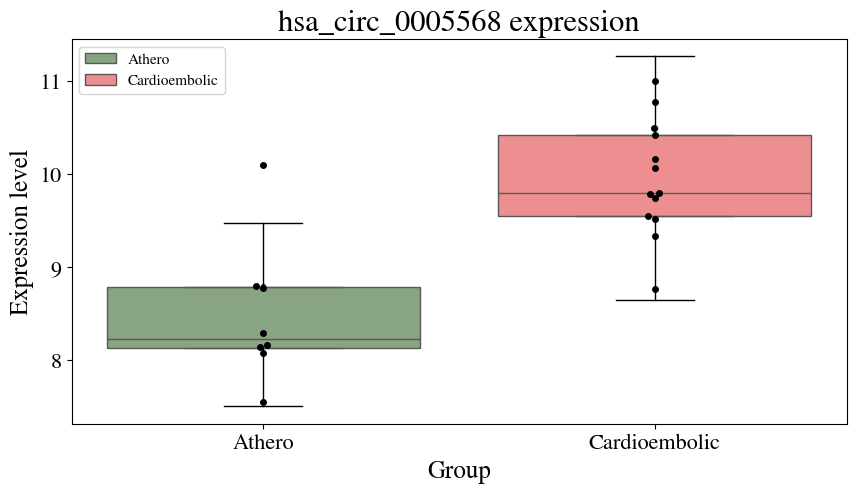

In [24]:
study.show_expression_mod(id='hsa_circ_0005568', 
                      modality='circRNA', 
                      groups=('Athero', 'Cardioembolic'))

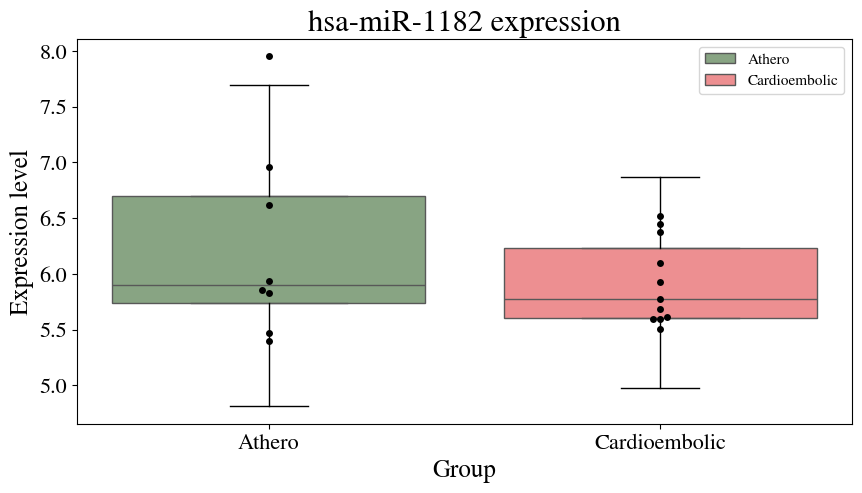

In [25]:
study.show_expression_mod(id='hsa-miR-1182', 
                      modality='miRNA', 
                      groups=('Athero', 'Cardioembolic'))

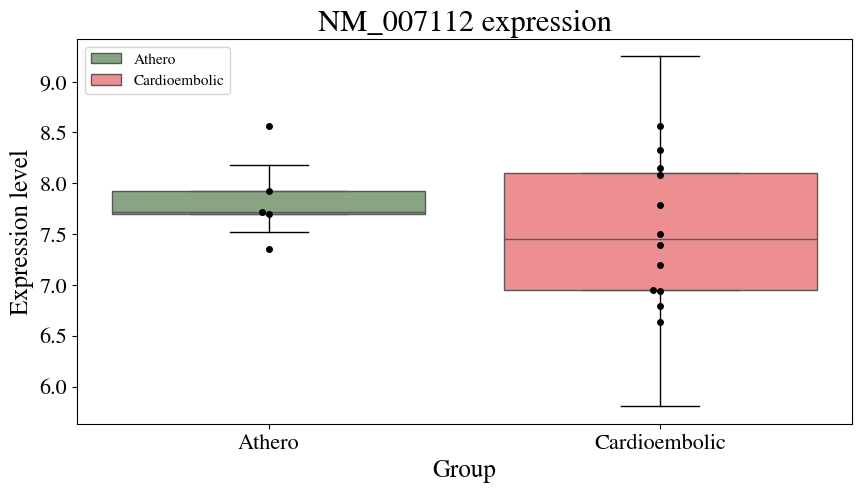

In [28]:
study.show_expression_mod(id='NM_007112', 
                      modality='mRNA', 
                      groups=('Athero', 'Cardioembolic'))

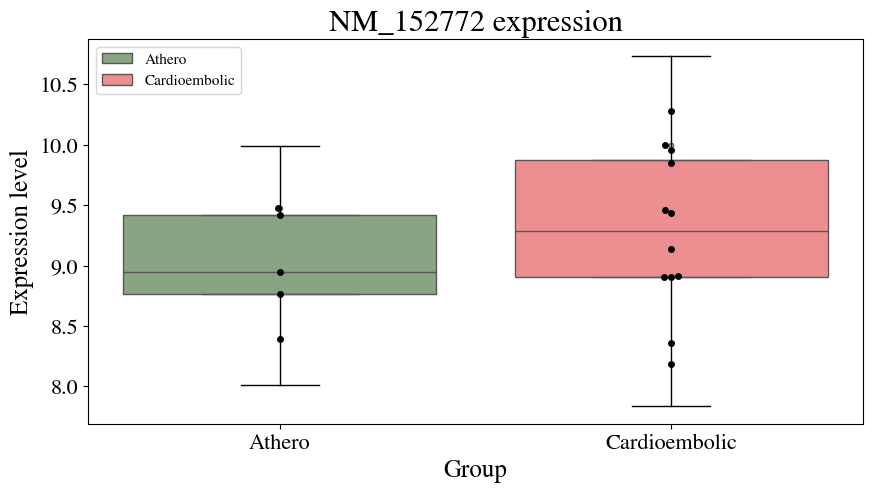

In [29]:
study.show_expression_mod(id='NM_152772',
                      modality='mRNA', 
                      groups=('Athero', 'Cardioembolic'))

## Visualization

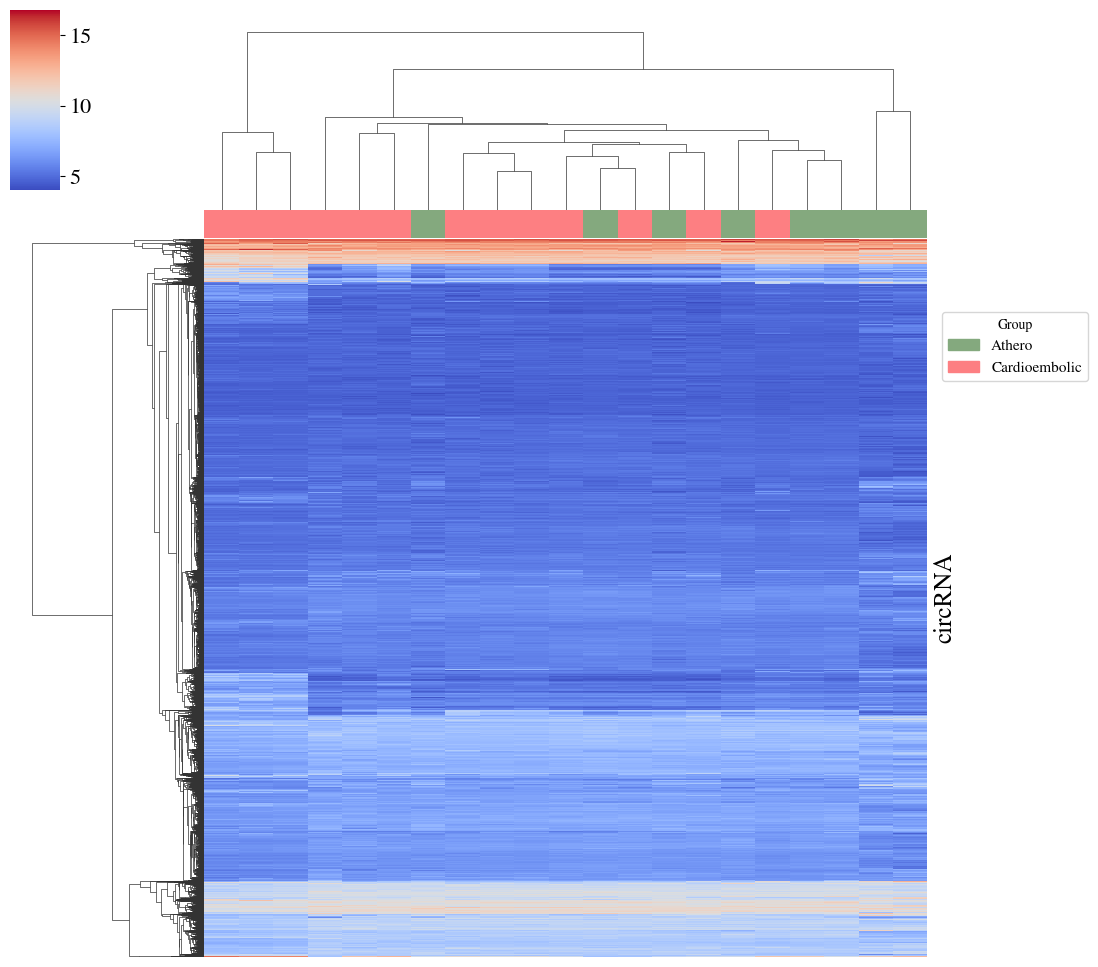

In [161]:
study.plot_clustered_heatmap(modality='circRNA', 
                             groups=('Athero', 'Cardioembolic'))

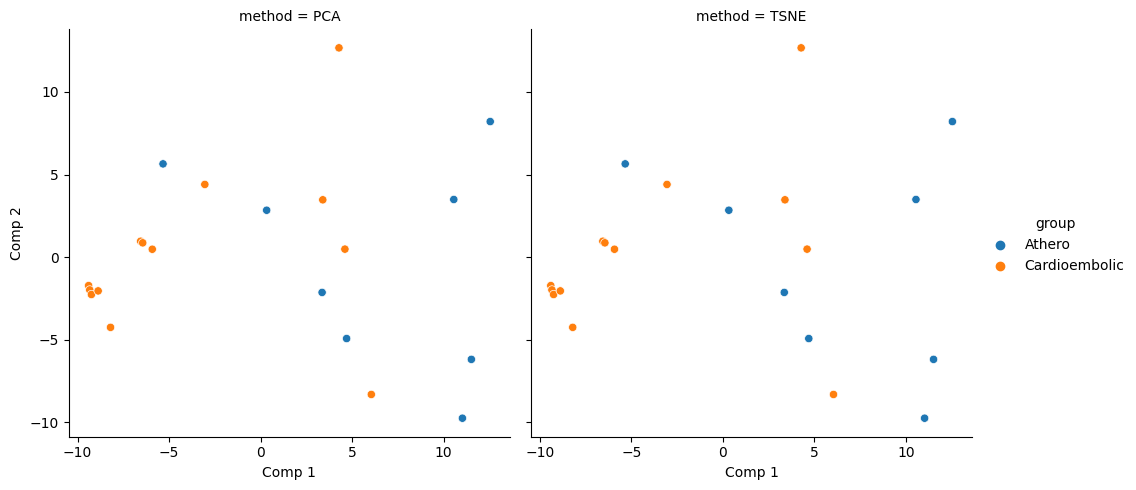

In [15]:
study.draw_projection(modality='circRNA', groups=('Athero', 'Cardioembolic'))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
circRNA
Test Accuracy: 0.8571428571428571

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.92      0.85      0.88        13

    accuracy                           0.86        21
   macro avg       0.85      0.86      0.85        21
weighted avg       0.86      0.86      0.86        21


Confusion Matrix:
[[ 7  1]
 [ 2 11]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


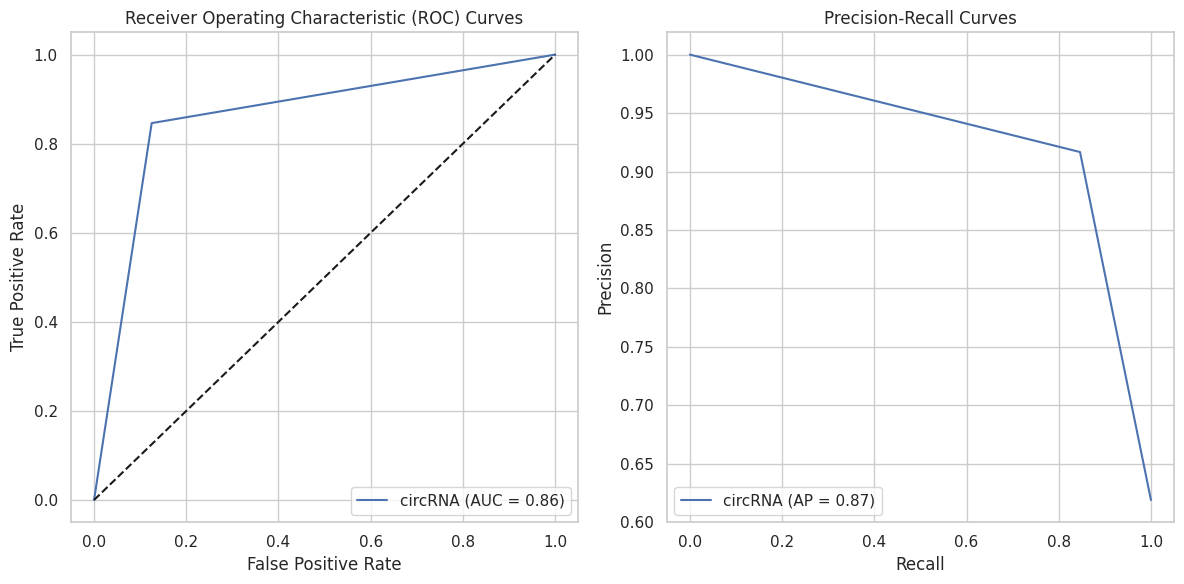

In [16]:
model = study.classifier(modality='circRNA', groups=('Athero', 'Cardioembolic'), plot_roc=True)

In [17]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score


## Run MOFA

In [18]:
mofa = study.prepare_mofa(num_factors = 10)


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        


Features names not provided, using default naming convention:
- feature1_view1, featureD_viewM

Successfully loaded view='mRNA' group='Athero' with N=5 samples and D=2476 features...
Successfully loaded view='mRNA' group='Cardioembolic' with N=10 samples and D=2476 features...
Successfully loaded view='mRNA' group='Undetermined' with N=4 samples and D=2476 features...
Successfully loaded view='Methylation' group='Athero' with N=5 samples and D=131 features...
Successfully loaded view='Methylation' group='Cardioembolic' with N=10 samples and D=131 features...
Successfully loaded view='Methylation' group='Undetermined' with N=4 samples and D=131 features...
Successfully loaded view='miRNA' group='Athero' with N=5 samples and D=673 features...
Successfully loaded view='miRNA' group='Cardioembolic' with N=10 samples and D=673 features...
Successfully loaded view='miRNA' group='Undetermined' with N=4 samples and D=673 features...
Successfully loaded view='circRNA' group='Athero' with N=5 sa

In [19]:
mofa = study.run_mofa()



######################################
## Training the model with seed 978301 ##
######################################




ELBO before training: -599046.41 

Iteration 1: time=0.03, ELBO=-133771.40, deltaELBO=465275.013 (77.66927669%), Factors=10
Iteration 2: time=0.05, ELBO=-110736.77, deltaELBO=23034.631 (3.84521644%), Factors=10
Iteration 3: time=0.02, ELBO=-95783.28, deltaELBO=14953.484 (2.49621462%), Factors=10
Iteration 4: time=0.02, ELBO=-90813.63, deltaELBO=4969.651 (0.82959365%), Factors=10
Iteration 5: time=0.02, ELBO=-88661.42, deltaELBO=2152.206 (0.35927206%), Factors=10
Iteration 6: time=0.02, ELBO=-87470.37, deltaELBO=1191.050 (0.19882438%), Factors=10
Iteration 7: time=0.01, ELBO=-86707.33, deltaELBO=763.047 (0.12737701%), Factors=10
Iteration 8: time=0.02, ELBO=-86167.25, deltaELBO=540.076 (0.09015597%), Factors=10
Iteration 9: time=0.02, ELBO=-85759.46, deltaELBO=407.787 (0.06807266%), Factors=10
Iteration 10: time=0.02, ELBO=-85447.38, deltaELBO=312.085 (0.05209693%), Factors=10
Iteration 11: time=0.02, ELBO=-85201.32, deltaELBO=246.059 (0.04107504%), Factors=10
Iteration 12: time=0.02, E

In [ ]:
study.draw_projection(modality='MOFA', groups=('Athero', 'Cardioembolic'))

In [ ]:
study.plot_clustered_heatmap(modality='MOFA', 
                             groups=('Athero', 'Cardioembolic'))

## Run BioMGNN

In [ ]:
study.run_graph()

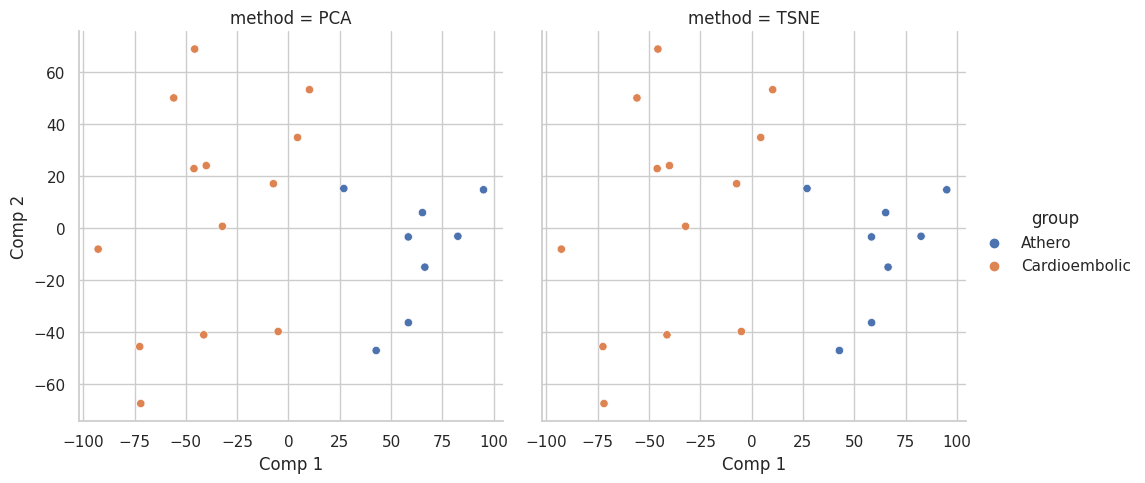

In [28]:
study.draw_projection(modality='GCN', groups=('Athero', 'Cardioembolic'))

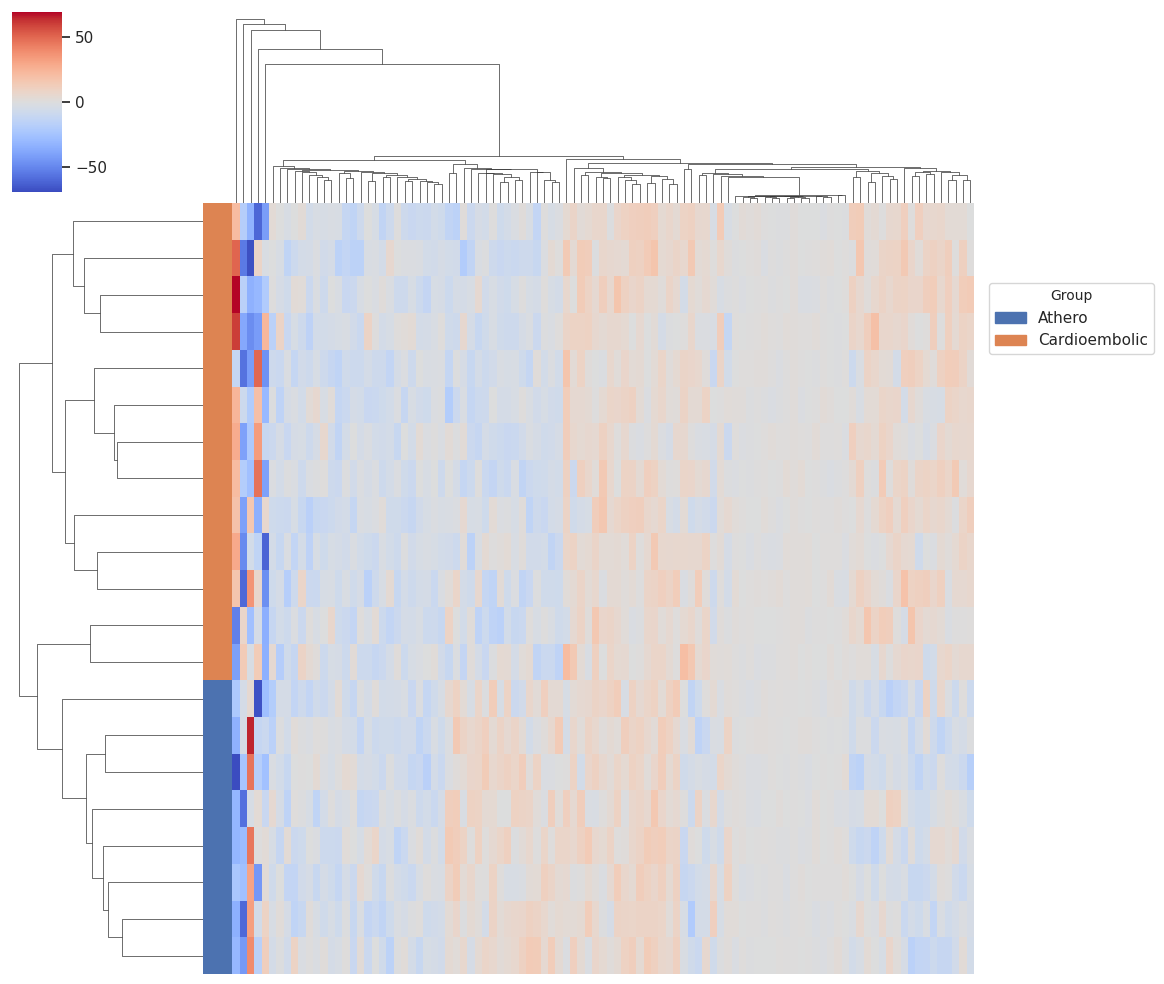

In [29]:
gT = study.plot_clustered_heatmap(modality='GCN', 
                             groups=('Athero', 'Cardioembolic'))

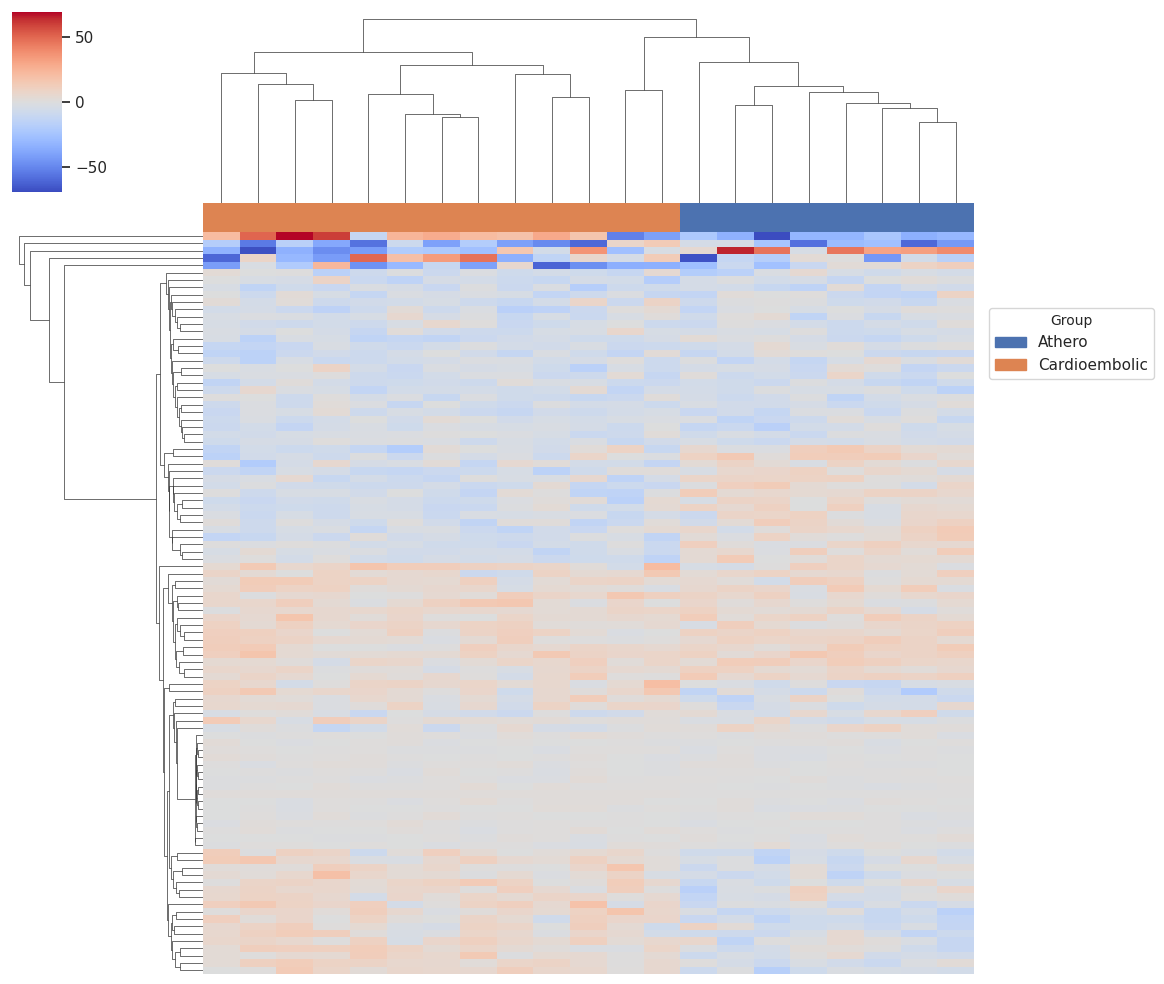

In [30]:
g = study.plot_clustered_heatmap(modality='GCN', 
                             groups=('Athero', 'Cardioembolic')
                            )


## Compare results

In [43]:
from multiomics.study import render_mpl_table

In [ ]:
results = [study.classifier(modality=modality, groups=('Athero', 'Cardioembolic'), plot_roc=False) for modality in study.data.keys()]


In [ ]:
result_table = pd.DataFrame([{'model': r['modality'], **r['metrics']} for r in results]).set_index('model').T

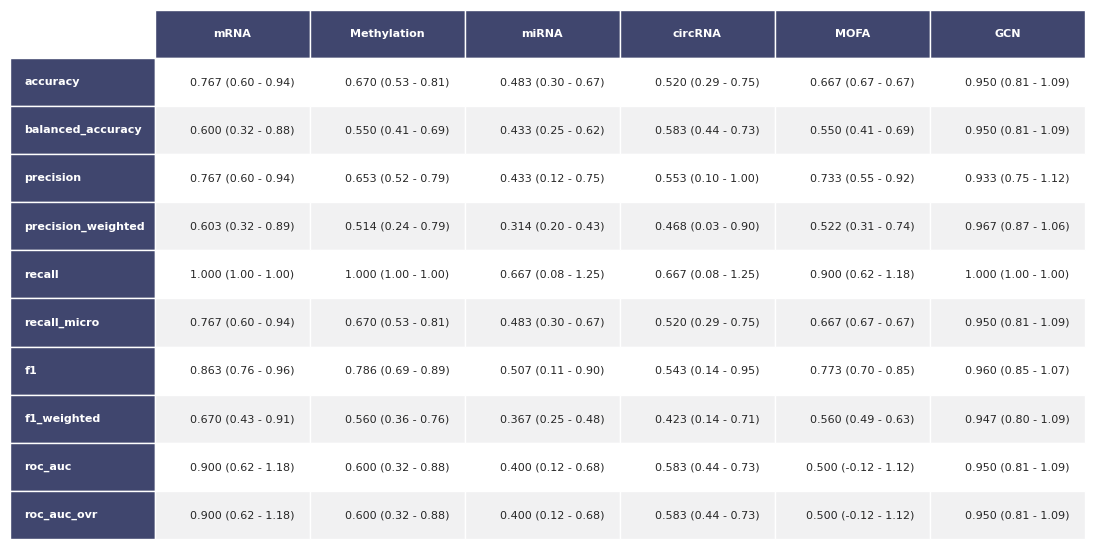

In [45]:

fig, ax = render_mpl_table(result_table, header_columns=0, col_width=2.0, font_size=8)
plt.show()